## Imports


In [ ]:
# !pip install transformers
# !pip install torch

In [2]:
import pandas as pd
import html
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from transformers import BertTokenizer, BertModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/olgapetrukhina/nltk_data...


True

## 1. Очистите данные от лишних символов и стоп-слов

In [8]:
df = pd.read_csv('socialmedia_relevant_cols.csv', encoding='latin1')
df = df.drop_duplicates()

In [10]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z#]', ' ', text).lower()

    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in text.split() if word not in stop_words]

    return ' '.join(filtered_text)

In [12]:
df['Cleaned_Text'] = df['text'].apply(clean_text)

In [14]:
df

text choose_one  \
0                     Just happened a terrible car crash   Relevant   
1      Our Deeds are the Reason of this #earthquake M...   Relevant   
2      Heard about #earthquake is different cities, s...   Relevant   
3      there is a forest fire at spot pond, geese are...   Relevant   
4                 Forest fire near La Ronge Sask. Canada   Relevant   
...                                                  ...        ...   
10866  Suicide bomber kills 15 in Saudi security site...   Relevant   
10868  Green Line derailment in Chicago http://t.co/U...   Relevant   
10869  Two giant cranes holding a bridge collapse int...   Relevant   
10873  The Latest: More Homes Razed by Northern Calif...   Relevant   
10875  #CityofCalgary has activated its Municipal Eme...   Relevant   

       class_label                                       Cleaned_Text  
0                1                        happened terrible car crash  
1                1      deeds reason #earthquake may allah forgive us  
2                1  heard #earthquake different cities stay safe e...  
3                1  forest fire spot pond geese fleeing across str...  
4                1              forest fire near la ronge sask canada  
...            ...                                                ...  
10866            1  suicide bomber kills saudi security site mosqu...  
10868            1                      green line derailment chicago  
10869            1  two giant cranes holding bridge collapse nearb...  
10873            1  latest homes razed northern california wildfir...  
10875            1  #cityofcalgary activated municipal emergency p...  

[10706 rows x 4 columns]

## 2. Постройте информативные графики, демонстрирующие специфику датасета

**2.1 WordCloud со всеми словами датасета**

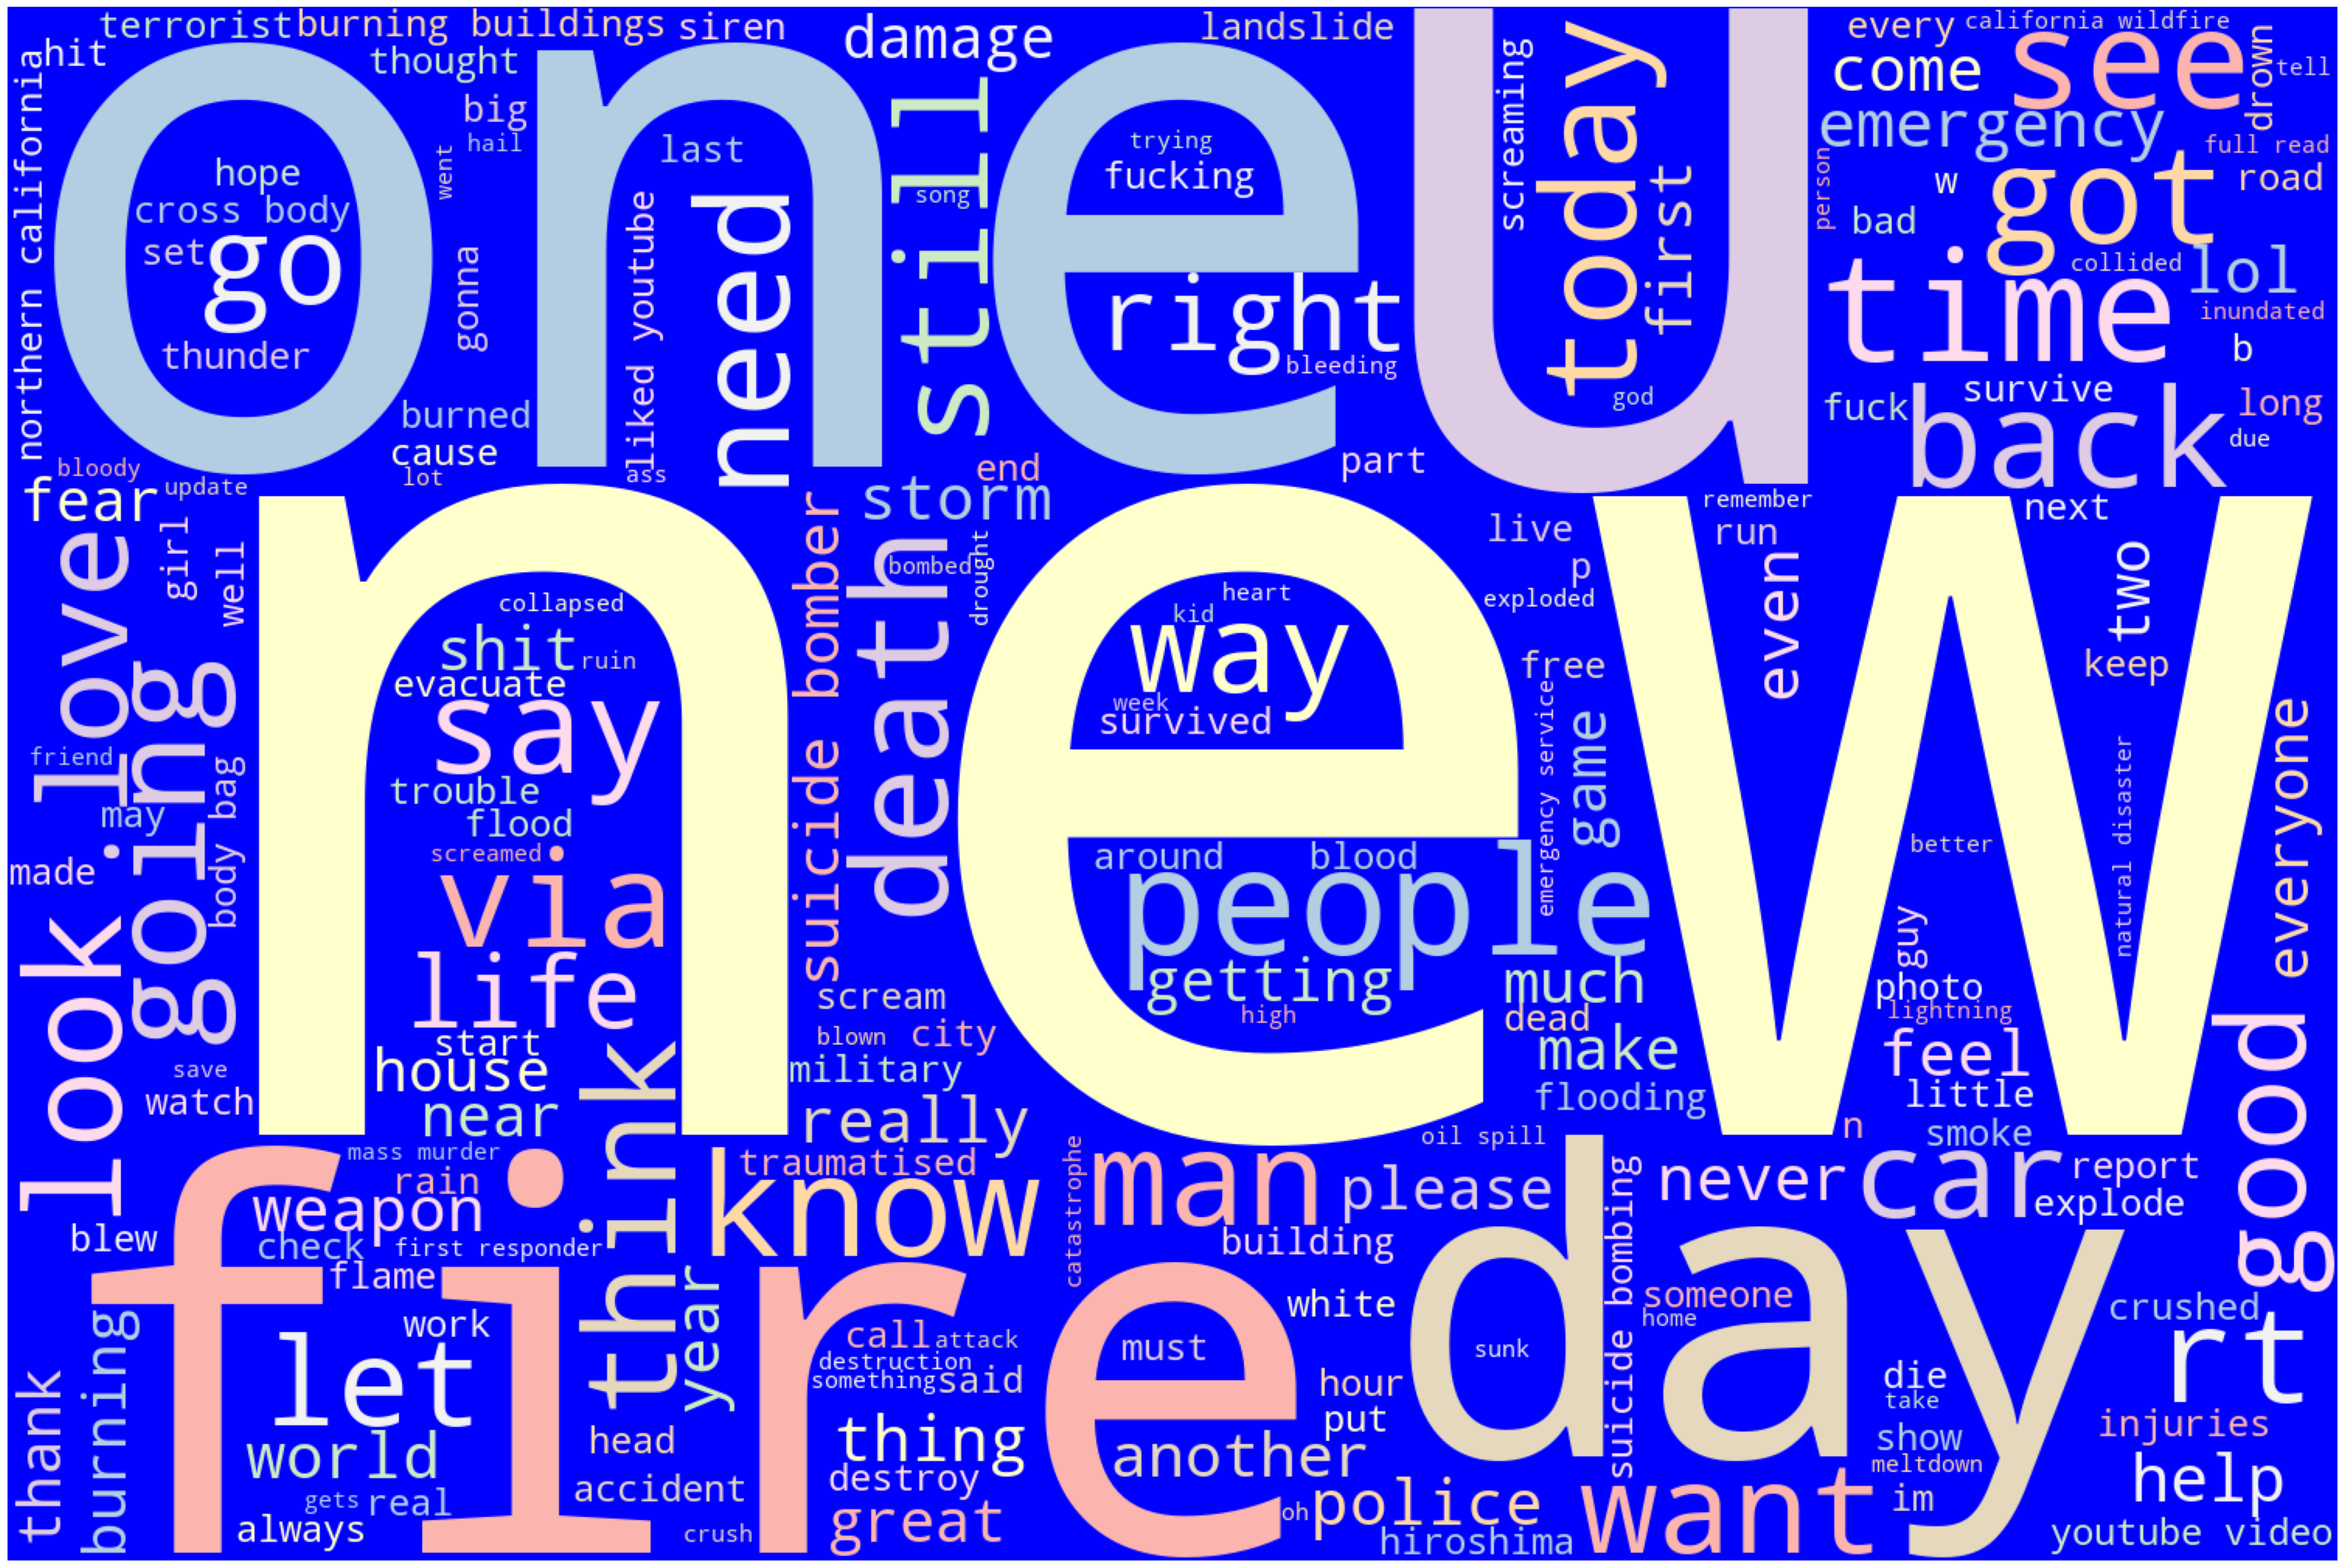

In [16]:
text = df['Cleaned_Text']

wordcloud = WordCloud(width = 1500,
                      height = 1000,
                      background_color='blue',
                      colormap='Pastel1').generate(', '.join(text))
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**2.2 WordCloud только с #**

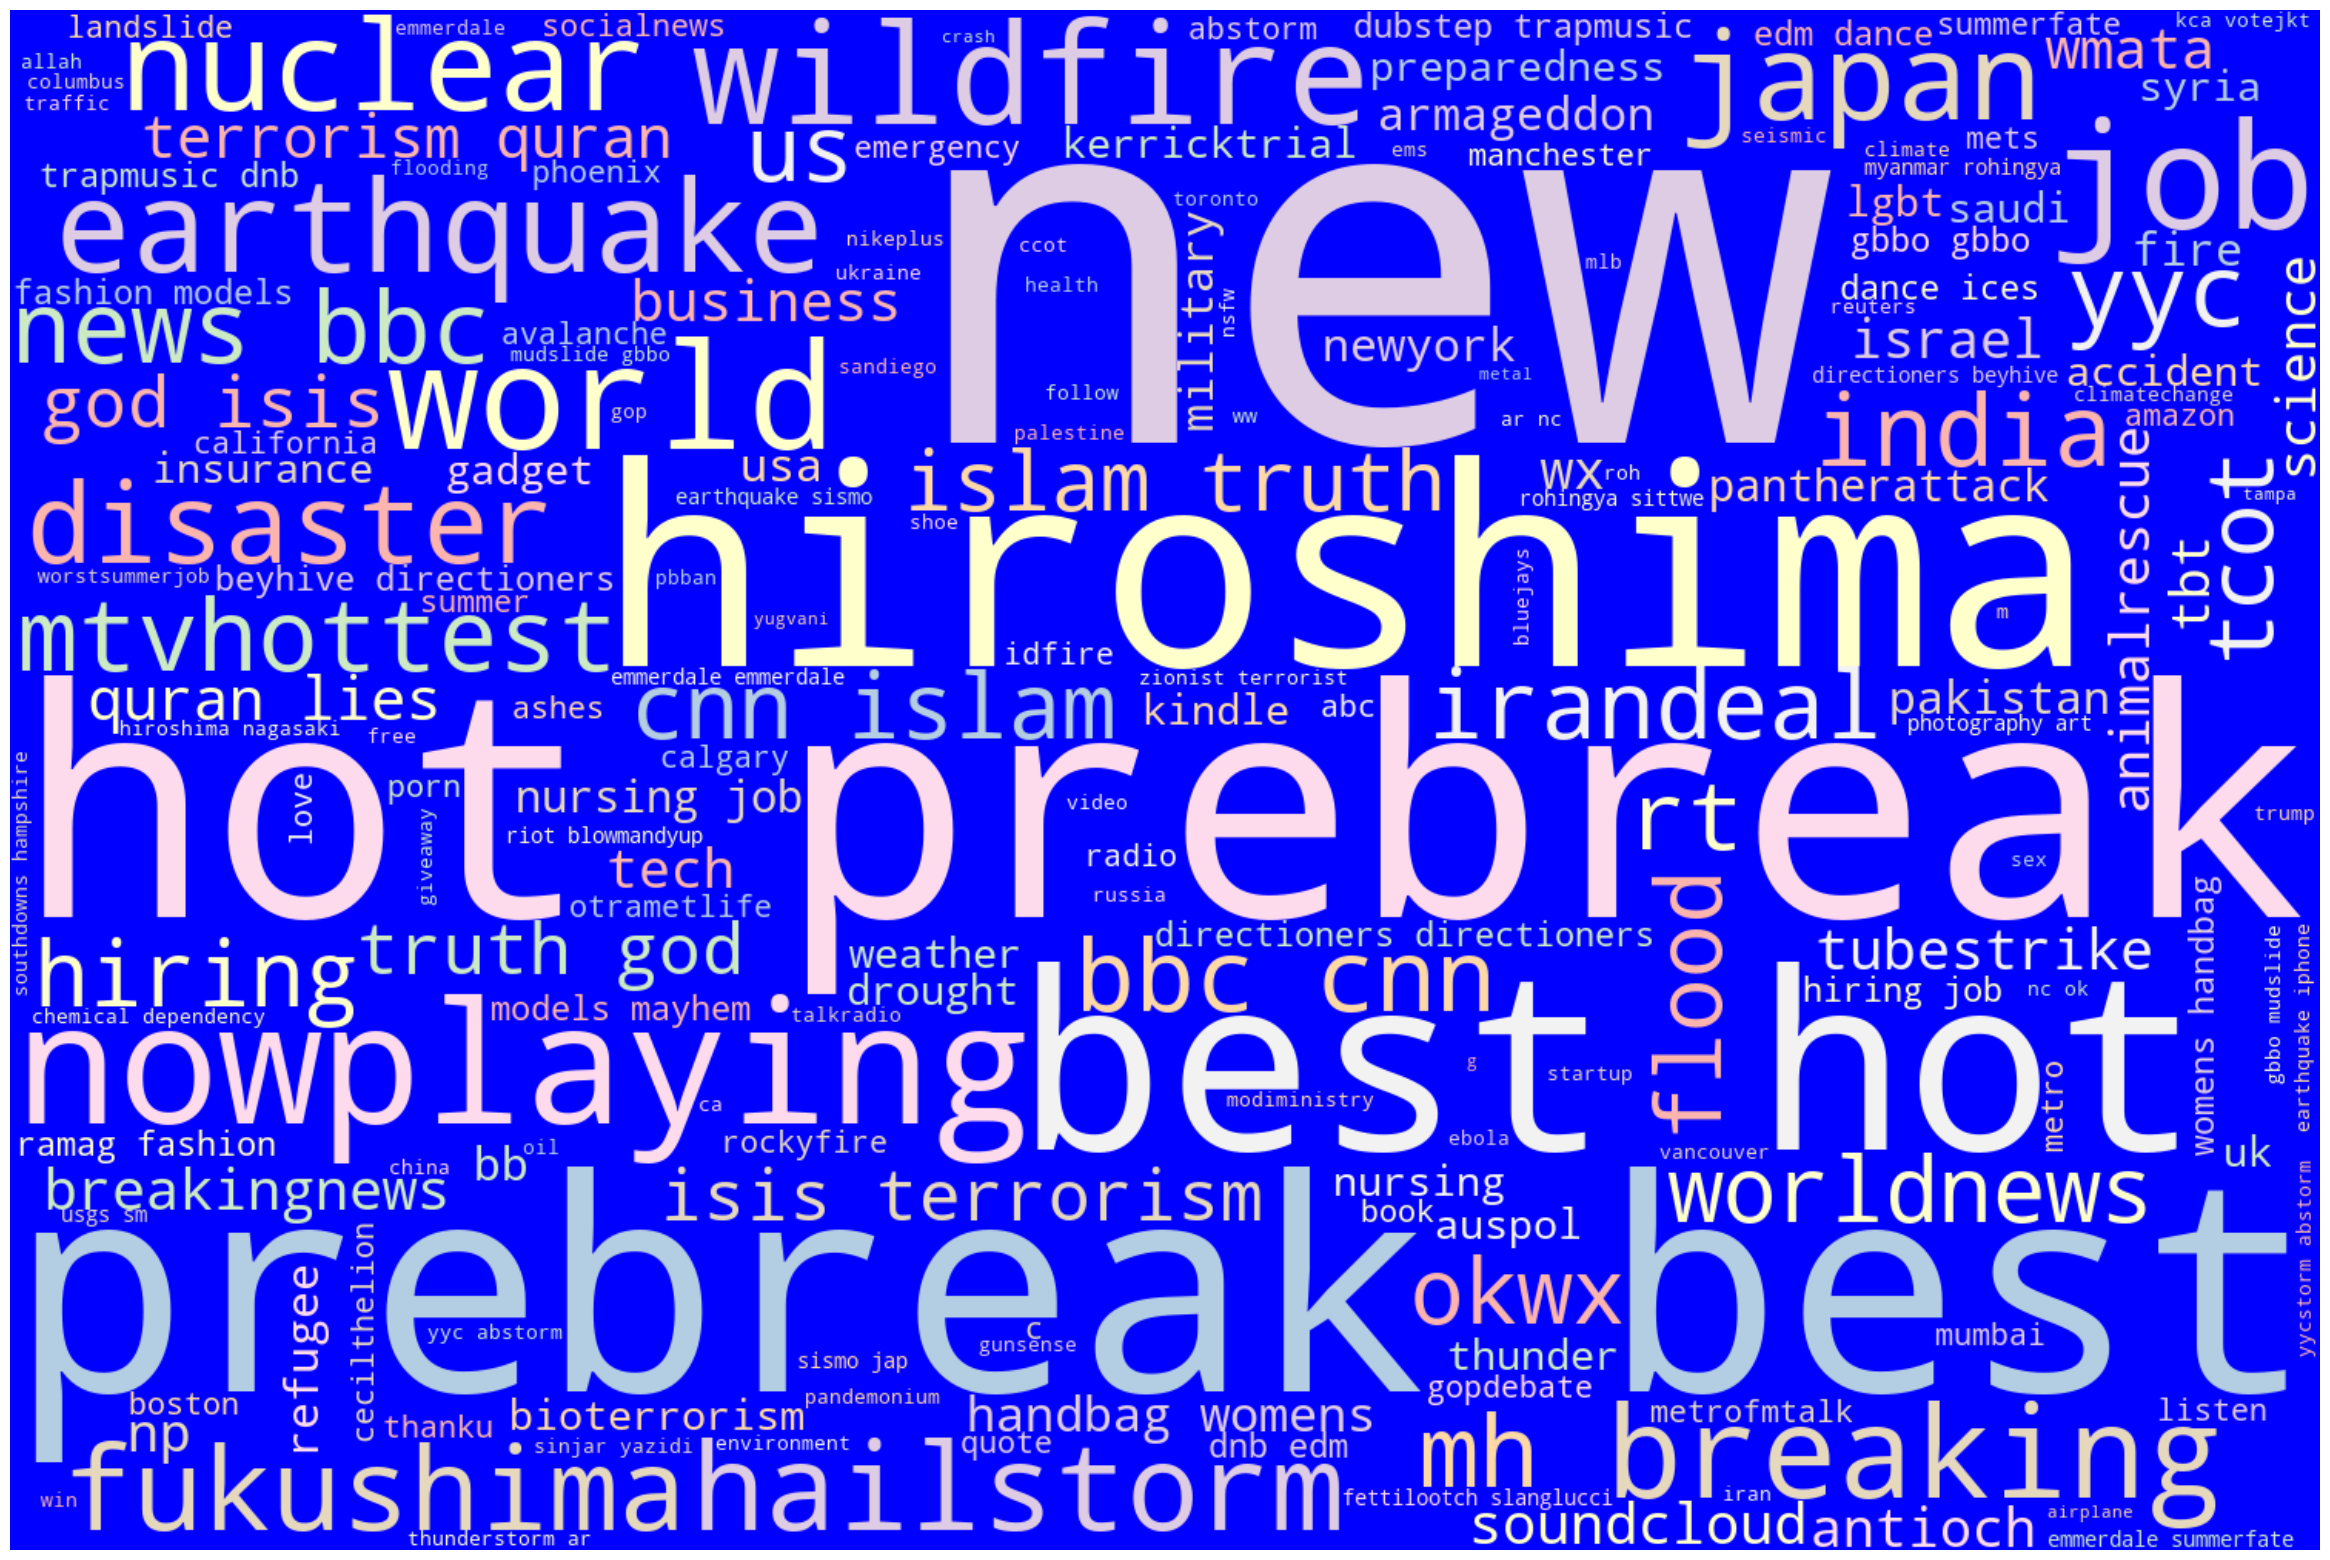

In [17]:
def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return ' '.join(hashtags)

df['Hashtags'] = df['Cleaned_Text'].apply(extract_hashtags)

wordcloud = WordCloud(width=1500,
                      height=1000,
                      background_color='blue',
                      colormap='Pastel1').generate(' '.join(df['Hashtags']))

plt.figure(figsize=(30, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**2.3 Самые частотные биграмы**

In [22]:
def extract_bigrams(text):
    tokens = nltk.word_tokenize(text)
    bigrams = list(nltk.bigrams(tokens))
    return bigrams

df['Bigrams'] = df['Cleaned_Text'].apply(extract_bigrams)
flattened = [bigram for i in df['Bigrams'] for bigram in i]
bigrams = Counter(flattened)
print(bigrams.most_common(5))

[(('#', 'news'), 102), (('suicide', 'bomber'), 83), (('burning', 'buildings'), 71), (('gon', 'na'), 66), (('youtube', 'video'), 62)]


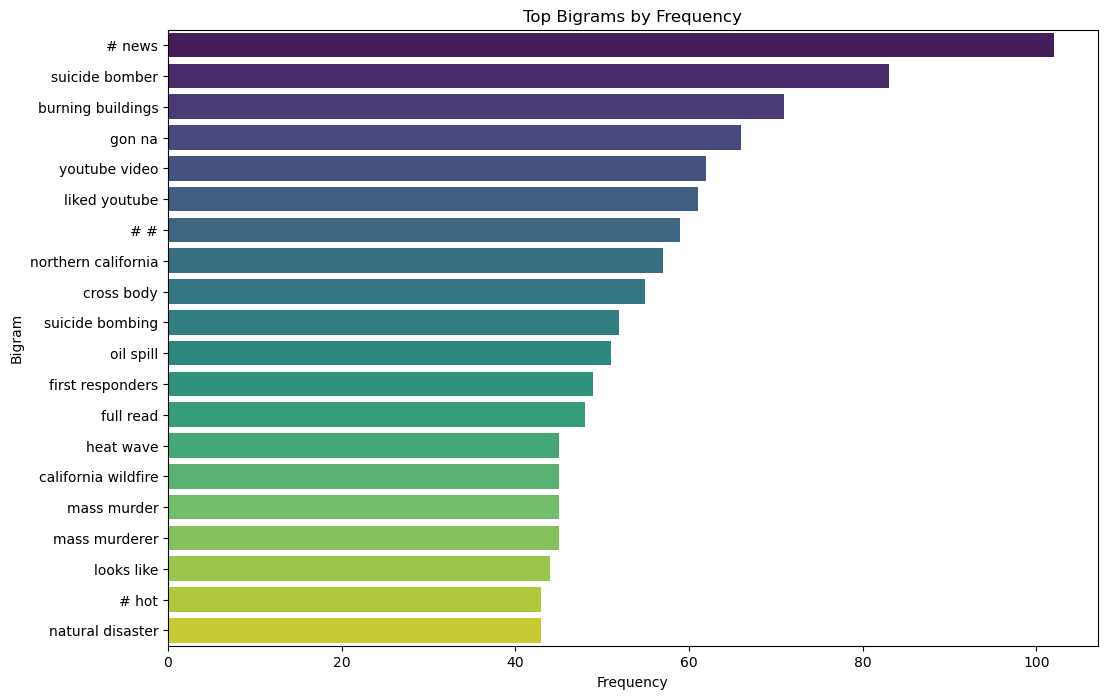

In [24]:
sorted_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
df_b = pd.DataFrame(sorted_bigrams, columns=['Bigram', 'Frequency'])
df_b['Bigram'] = df_b['Bigram'].apply(lambda x: ' '.join(x))

top_bigrams = df_b.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Top Bigrams by Frequency')
plt.show()

**2.4 Соотношение твитов про катастрофы и нет**

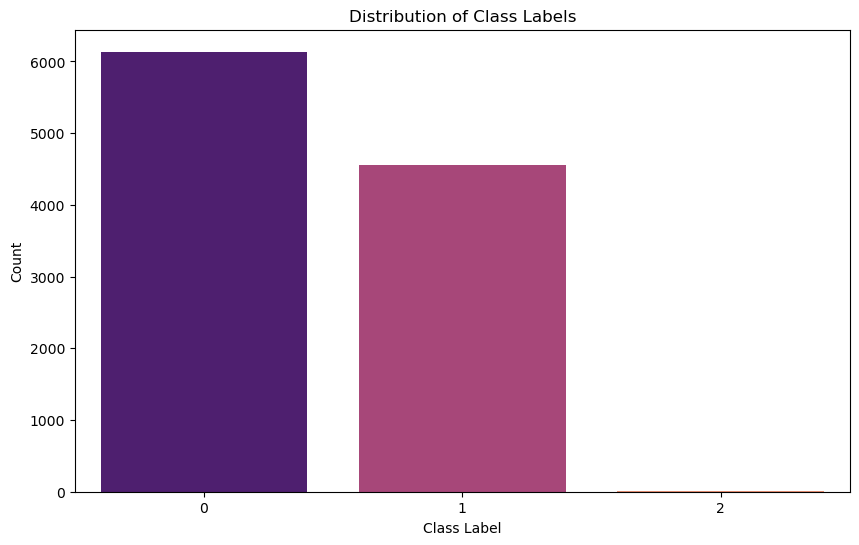

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class_label', palette='magma')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

## 3. Примените три способа токенизации

**3.1. 'По словам'**

принцип работы:


nltk способен разбивать тексты по разным принципам, в данном случае, он делит тексты по словам. отдельные слова определяются с помощью пробелов, знаков препинания, а также некоторых установленных правил (например, nltk может различать аббревиатуры)

In [28]:
def tokenize_nltk(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return word_tokenize(text)

In [30]:
df['Tokenize_NLTK'] = df['Cleaned_Text'].apply(tokenize_nltk)


**3.2. BPE**

принцип работы:

BPE - более сложная модель. она разбивает текст на слова, а слова - на отдельные буквы - и затем считает, какие комбинации букв встречаются чаще всего, чтобы объединить их. путем многократного повторения находится нужное кол-во новых символов, которые теперь воспринимаются как единое целое. в итоге текст кодируется эффективнее


In [32]:
with open('cleaned_tweets.txt', 'w', encoding='utf-8') as f:
    for text in df['Cleaned_Text']:
        f.write(f'{text}\n')

In [34]:
BPE_tokenizer = Tokenizer(models.BPE())

trainer = trainers.BpeTrainer(vocab_size=15000, min_frequency=5, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

BPE_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
BPE_tokenizer.train(files=['cleaned_tweets.txt'], trainer=trainer)

BPE_tokenizer.save("BPE_tokenizer.json")


In [36]:
tokenizer = Tokenizer.from_file("BPE_tokenizer.json")

def tokenize_BPE(text):
    tokens = tokenizer.encode(text)
    return tokens.tokens, tokens.ids

df[['BPE_tokens', 'BPE_ids']] = df['Cleaned_Text'].apply(lambda x: pd.Series(tokenize_BPE(x)))

**3.3. BERT**

принцип работы:

это еще более мощная модель, основанная на архитектуре трансформеров и обучающаяся на большом объеме текстов. в отличие от других моделей, она читает тексты и слева-направо, и справа-налево, что способствует лучшему контекстуальному пониманию слов.  как и в предыдущем алгоритме, текст разбивается на отдельные слова и затем символы; часто встречающиеся пары символов комбинируются, чтобы создать подслова.

In [38]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_BERT(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=80, return_tensors="pt")

def ids_attention_masks_and_tokens(text):
    tokens = tokenize_BERT(text)
    ids = tokens['input_ids'].squeeze().tolist()
    token_strs = tokenizer.convert_ids_to_tokens(ids)
    return ids, token_strs

df[['BERT_ids', 'BERT_tokens']] = df['Cleaned_Text'].apply(lambda x: pd.Series(ids_attention_masks_and_tokens(x)))


In [39]:
df.head()

text choose_one  class_label  \
0                 Just happened a terrible car crash   Relevant            1   
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1   
2  Heard about #earthquake is different cities, s...   Relevant            1   
3  there is a forest fire at spot pond, geese are...   Relevant            1   
4             Forest fire near La Ronge Sask. Canada   Relevant            1   

                                        Cleaned_Text     Hashtags  \
0                        happened terrible car crash                
1      deeds reason #earthquake may allah forgive us  #earthquake   
2  heard #earthquake different cities stay safe e...  #earthquake   
3  forest fire spot pond geese fleeing across str...                
4              forest fire near la ronge sask canada                

                                             Bigrams  \
0  [(happened, terrible), (terrible, car), (car, ...   
1  [(deeds, reason), (reason, #), (#, earthquake)...   
2  [(heard, #), (#, earthquake), (earthquake, dif...   
3  [(forest, fire), (fire, spot), (spot, pond), (...   
4  [(forest, fire), (fire, near), (near, la), (la...   

                                       Tokenize_NLTK  \
0                   [happened, terrible, car, crash]   
1  [deeds, reason, earthquake, may, allah, forgiv...   
2  [heard, earthquake, different, cities, stay, s...   
3  [forest, fire, spot, pond, geese, fleeing, acr...   
4      [forest, fire, near, la, ronge, sask, canada]   

                                          BPE_tokens  \
0                   [happened, terrible, car, crash]   
1  [de, eds, reason, #, earthquake, may, allah, f...   
2  [heard, #, earthquake, different, cities, stay...   
3  [forest, fire, spot, pond, ge, ese, fle, eing,...   
4  [forest, fire, near, la, ron, ge, s, ask, canada]   

                                             BPE_ids  \
0                             [1876, 3335, 293, 300]   
1  [49, 2631, 1894, 5, 986, 337, 4178, 176, 1341,...   
2        [1258, 5, 986, 2673, 3649, 1401, 1286, 938]   
3  [626, 140, 1726, 4613, 72, 1597, 1562, 5239, 2...   
4      [626, 140, 481, 137, 682, 72, 24, 1900, 2674]   

                                            BERT_ids  \
0  [101, 3047, 6659, 2482, 5823, 102, 0, 0, 0, 0,...   
1  [101, 15616, 3114, 1001, 8372, 2089, 16455, 96...   
2  [101, 2657, 1001, 8372, 2367, 3655, 2994, 3647...   
3  [101, 3224, 2543, 3962, 8644, 28519, 14070, 24...   
4  [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...   

                                         BERT_tokens  
0  [[CLS], happened, terrible, car, crash, [SEP],...  
1  [[CLS], deeds, reason, #, earthquake, may, all...  
2  [[CLS], heard, #, earthquake, different, citie...  
3  [[CLS], forest, fire, spot, pond, geese, fleei...  
4  [[CLS], forest, fire, near, la, ron, ##ge, sas...

## 4. Сделайте одну векторизацию и 2 варианта эмбеддингов (один - предобученная модель (huggingface))

**4.1. TF-IDF**

принцип работы:

этот метод позволяет оценить, насколько важно слово, содержащее в конкретном тексте, относительно всех текстов. он преобразует текстовые данные в числовые признаки, которые может распознать модель. tf = сколько раз слово встречается в документе / кол-во слов в этом документе (какие слова важны в этом документе?), idf =  кол-во всех документов / кол-во документов, где встречается это слово (как часто/редко слово встречается во всех документах?). затем tf и idf перемножаются. таким образом, мы находим слова, которые типичны для этого документа, но нетипичны для других

In [42]:
tf_idf = TfidfVectorizer(max_features=5000)
matrix = tf_idf.fit_transform(df['Cleaned_Text'])

tf_df = pd.DataFrame(matrix.toarray(), columns=tf_idf.get_feature_names_out())

In [44]:
tf_df

aa  aba  abandoned  abbott  abbswinston       abc  abcnews  abe  \
0      0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
1      0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
2      0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
3      0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
4      0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
...    ...  ...        ...     ...          ...       ...      ...  ...   
10701  0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
10702  0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
10703  0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   
10704  0.0  0.0        0.0     0.0          0.0  0.395883      0.0  0.0   
10705  0.0  0.0        0.0     0.0          0.0  0.000000      0.0  0.0   

       ability  ablaze  ...  yrs  yyc  yycstorm  zak  zayn  zero  zionist  \
0          0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
1          0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
2          0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
3          0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
4          0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
...        ...     ...  ...  ...  ...       ...  ...   ...   ...      ...   
10701      0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
10702      0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
10703      0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
10704      0.0     0.0  ...  0.0  0.0  0.000000  0.0   0.0   0.0      0.0   
10705      0.0     0.0  ...  0.0  0.0  0.458747  0.0   0.0   0.0      0.0   

       zombie  zone  zouma  
0         0.0   0.0    0.0  
1         0.0   0.0    0.0  
2         0.0   0.0    0.0  
3         0.0   0.0    0.0  
4         0.0   0.0    0.0  
...       ...   ...    ...  
10701     0.0   0.0    0.0  
10702     0.0   0.0    0.0  
10703     0.0   0.0    0.0  
10704     0.0   0.0    0.0  
10705     0.0   0.0    0.0  

[10706 rows x 5000 columns]

**4.2. Word2Vec**

принцип работы:

в отличие от TF-IDF, о котором я писала выше, этот метод учитывает контекст, поскольку обучается на больших объемах текстов. векторы слов, которые создает этот метод, учитывает их смысл и взаимосвязь с другими словами через окружение. если слова часто встречаются рядом в тексте, их векторы будут ближе друг к другу

In [46]:
list_ = df['Cleaned_Text'].apply(lambda x: x.split()).tolist()
w2v_model = Word2Vec(list_, vector_size=50, min_count=10)

In [48]:
w2v_model.wv.most_similar("fire")

[('sinkhole', 0.997873842716217),
 ('whirlwind', 0.9976946711540222),
 ('around', 0.9976649284362793),
 ('alarm', 0.9976243376731873),
 ('gets', 0.9975901246070862),
 ('camp', 0.9975886344909668),
 ('song', 0.9975771903991699),
 ('change', 0.9974938631057739),
 ('says', 0.9974004030227661),
 ('death', 0.9973999857902527)]

In [50]:
w2v_model.wv.most_similar("disaster")

[('devastated', 0.9962146878242493),
 ('obama', 0.9961563944816589),
 ('typhoon', 0.9957579970359802),
 ('saipan', 0.994975209236145),
 ('signs', 0.9949002861976624),
 ('declaration', 0.9942044615745544),
 ('soudelor', 0.992398202419281),
 ('nuclear', 0.9912501573562622),
 ('marians', 0.9907585978507996),
 ('gold', 0.9903753995895386)]

In [52]:
w2v_model.wv.most_similar("hiroshima")

[('atomic', 0.998200535774231),
 ('anniversary', 0.9980891942977905),
 ('marks', 0.9970194697380066),
 ('th', 0.9967408776283264),
 ('years', 0.9965969324111938),
 ('japan', 0.9963495135307312),
 ('nagasaki', 0.9960078001022339),
 ('still', 0.9956610798835754),
 ('bombing', 0.9951542615890503),
 ('bombs', 0.9950836300849915)]

**4.3. Hugging Face** - https://huggingface.co/fse/word2vec-google-news-300


In [54]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

def word2vec(text, model):
    embeddings = []
    words = []
    for word in text.split():
        if word in model:
            embeddings.append(model[word])
            words.append(word)
    if embeddings:
        return np.mean(embeddings, axis=0), words
    else:
        return np.zeros(model.vector_size), []

df['Word2Vec'] = df['Cleaned_Text'].apply(lambda x: word2vec(x, model))
df['Word2Vec_Embeddings'] = df['Word2Vec'].apply(lambda x: x[0])
df['Word2Vec_Words'] = df['Word2Vec'].apply(lambda x: x[1])

In [55]:
df.head()

text choose_one  class_label  \
0                 Just happened a terrible car crash   Relevant            1   
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1   
2  Heard about #earthquake is different cities, s...   Relevant            1   
3  there is a forest fire at spot pond, geese are...   Relevant            1   
4             Forest fire near La Ronge Sask. Canada   Relevant            1   

                                        Cleaned_Text     Hashtags  \
0                        happened terrible car crash                
1      deeds reason #earthquake may allah forgive us  #earthquake   
2  heard #earthquake different cities stay safe e...  #earthquake   
3  forest fire spot pond geese fleeing across str...                
4              forest fire near la ronge sask canada                

                                             Bigrams  \
0  [(happened, terrible), (terrible, car), (car, ...   
1  [(deeds, reason), (reason, #), (#, earthquake)...   
2  [(heard, #), (#, earthquake), (earthquake, dif...   
3  [(forest, fire), (fire, spot), (spot, pond), (...   
4  [(forest, fire), (fire, near), (near, la), (la...   

                                       Tokenize_NLTK  \
0                   [happened, terrible, car, crash]   
1  [deeds, reason, earthquake, may, allah, forgiv...   
2  [heard, earthquake, different, cities, stay, s...   
3  [forest, fire, spot, pond, geese, fleeing, acr...   
4      [forest, fire, near, la, ronge, sask, canada]   

                                          BPE_tokens  \
0                   [happened, terrible, car, crash]   
1  [de, eds, reason, #, earthquake, may, allah, f...   
2  [heard, #, earthquake, different, cities, stay...   
3  [forest, fire, spot, pond, ge, ese, fle, eing,...   
4  [forest, fire, near, la, ron, ge, s, ask, canada]   

                                             BPE_ids  \
0                             [1876, 3335, 293, 300]   
1  [49, 2631, 1894, 5, 986, 337, 4178, 176, 1341,...   
2        [1258, 5, 986, 2673, 3649, 1401, 1286, 938]   
3  [626, 140, 1726, 4613, 72, 1597, 1562, 5239, 2...   
4      [626, 140, 481, 137, 682, 72, 24, 1900, 2674]   

                                            BERT_ids  \
0  [101, 3047, 6659, 2482, 5823, 102, 0, 0, 0, 0,...   
1  [101, 15616, 3114, 1001, 8372, 2089, 16455, 96...   
2  [101, 2657, 1001, 8372, 2367, 3655, 2994, 3647...   
3  [101, 3224, 2543, 3962, 8644, 28519, 14070, 24...   
4  [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...   

                                         BERT_tokens  \
0  [[CLS], happened, terrible, car, crash, [SEP],...   
1  [[CLS], deeds, reason, #, earthquake, may, all...   
2  [[CLS], heard, #, earthquake, different, citie...   
3  [[CLS], forest, fire, spot, pond, geese, fleei...   
4  [[CLS], forest, fire, near, la, ron, ##ge, sas...   

                                            Word2Vec  \
0  ([0.10748291, 0.022125244, 0.08850098, -0.0783...   
1  ([0.18487549, 0.07070923, 0.17469533, 0.132242...   
2  ([0.005238851, -0.036946613, 0.03989665, 0.101...   
3  ([0.102868654, 0.1349566, 0.012228394, 0.04846...   
4  ([0.08525391, -0.011193847, 0.0027526855, 0.13...   

                                 Word2Vec_Embeddings  \
0  [0.10748291, 0.022125244, 0.08850098, -0.07830...   
1  [0.18487549, 0.07070923, 0.17469533, 0.1322428...   
2  [0.005238851, -0.036946613, 0.03989665, 0.1016...   
3  [0.102868654, 0.1349566, 0.012228394, 0.048461...   
4  [0.08525391, -0.011193847, 0.0027526855, 0.136...   

                                      Word2Vec_Words  
0                   [happened, terrible, car, crash]  
1           [deeds, reason, may, allah, forgive, us]  
2   [heard, different, cities, stay, safe, everyone]  
3  [forest, fire, spot, pond, geese, fleeing, acr...  
4                   [forest, fire, near, la, canada]

## 5. Визуализируйте близость получившихся эмбеддингов, цветами окрасьте разные классы

принцип работы:

для снижения размерности я использую **t-SNE**, который для точек высчитыает вероятность того, могут ли они быть соседями, используя расстояния между ними. Затем создается распределение вероятностей для точек в низкоразмерном пространстве (в данном случае, в двумерном), похожие точки оказываются рядом

In [60]:
word2vec_emb = np.stack(df['Word2Vec_Embeddings'].values)
labels = df['class_label'].values
list_ = df['Word2Vec_Words'].values

tsne = TSNE(n_components=2, random_state=42)
tsne_res = tsne.fit_transform(word2vec_emb)

In [66]:
df_tsne = pd.DataFrame(tsne_res, columns=['tsne1', 'tsne2'])
df_tsne['label'] = labels
df_tsne['words'] = list_
df_tsne['label'] = df_tsne['label'].map({0: 'not a catastrophe', 1: 'catastrophe'})

/var/folders/xm/xwwht8gd57jc67xq9xgfvmlm0000gn/T/ipykernel_6201/2852501808.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


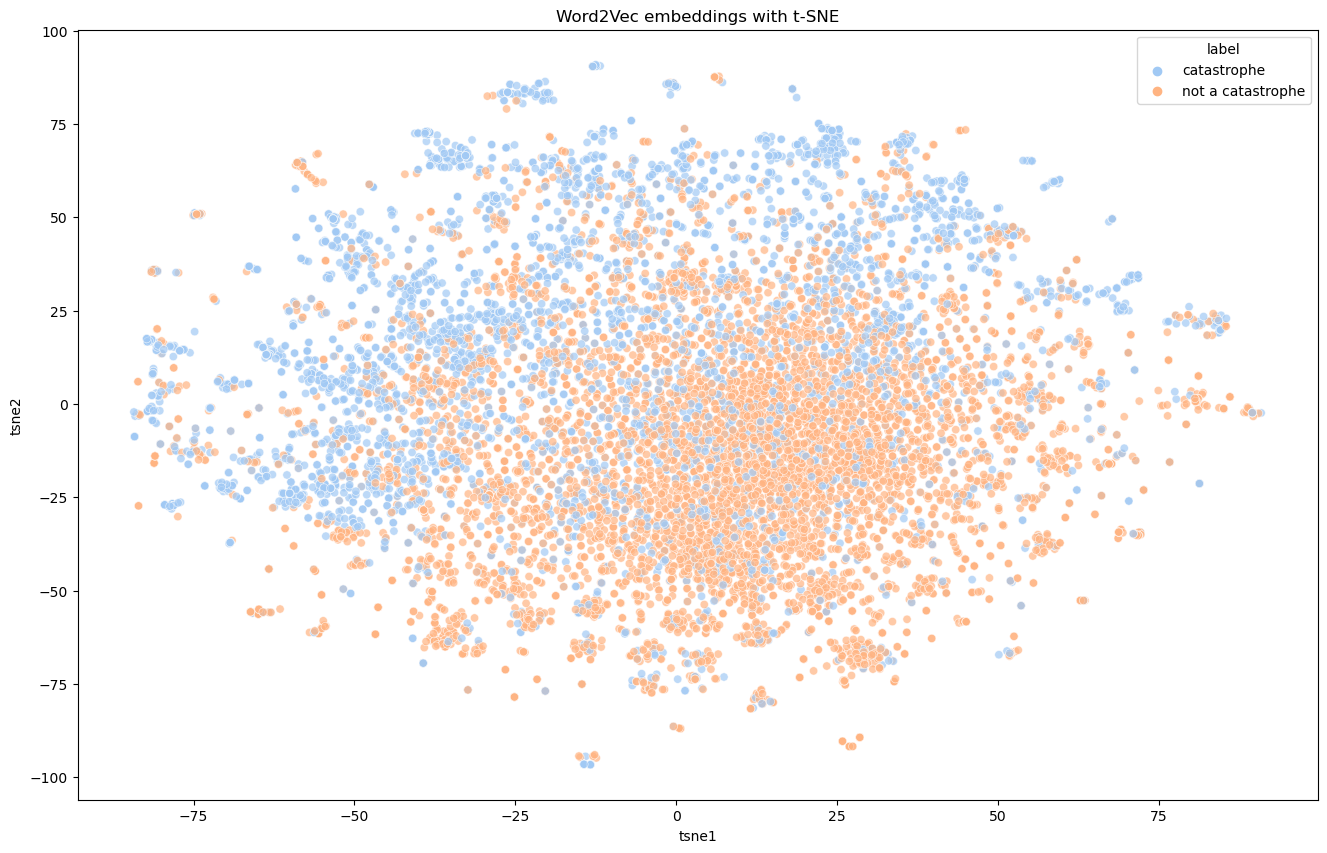

In [74]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='label', 
    palette=sns.color_palette("pastel", len(df_tsne['label'].unique())),
    data=df_tsne,
    legend="full",
    alpha=0.7
)

plt.title('Word2Vec embeddings with t-SNE')
plt.show()

**Word Similarity**

In [ ]:
keys = ['disaster', 'nuclear',  'scared', 'world', 'twitter', 'happy', 'hero', 'new', 'murder', 'quaran']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    if word in model:
        for similar_word, _ in model.most_similar(word, topn=30):
            if similar_word in model:
                words.append(similar_word)
                embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


In [ ]:
def plot(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 10))
    colors = sns.color_palette("hsv", len(labels))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.text(x[i], y[i], word, fontsize=9)
    plt.legend(loc=4)
    plt.title(title)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

plot('Similar words from Google News Word2Vec', keys, embeddings_2d, word_clusters, 0.7)

/var/folders/xm/xwwht8gd57jc67xq9xgfvmlm0000gn/T/ipykernel_97243/106270644.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


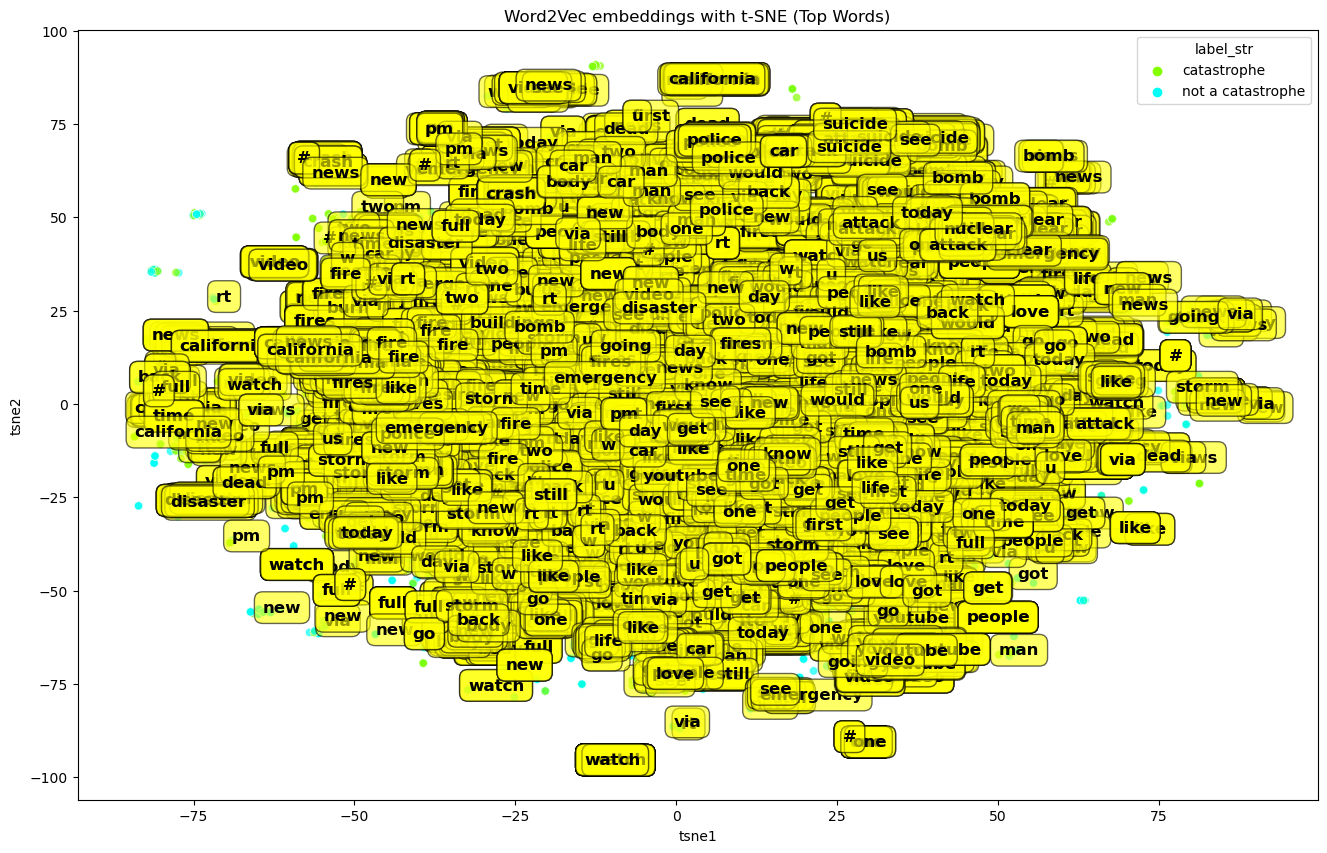

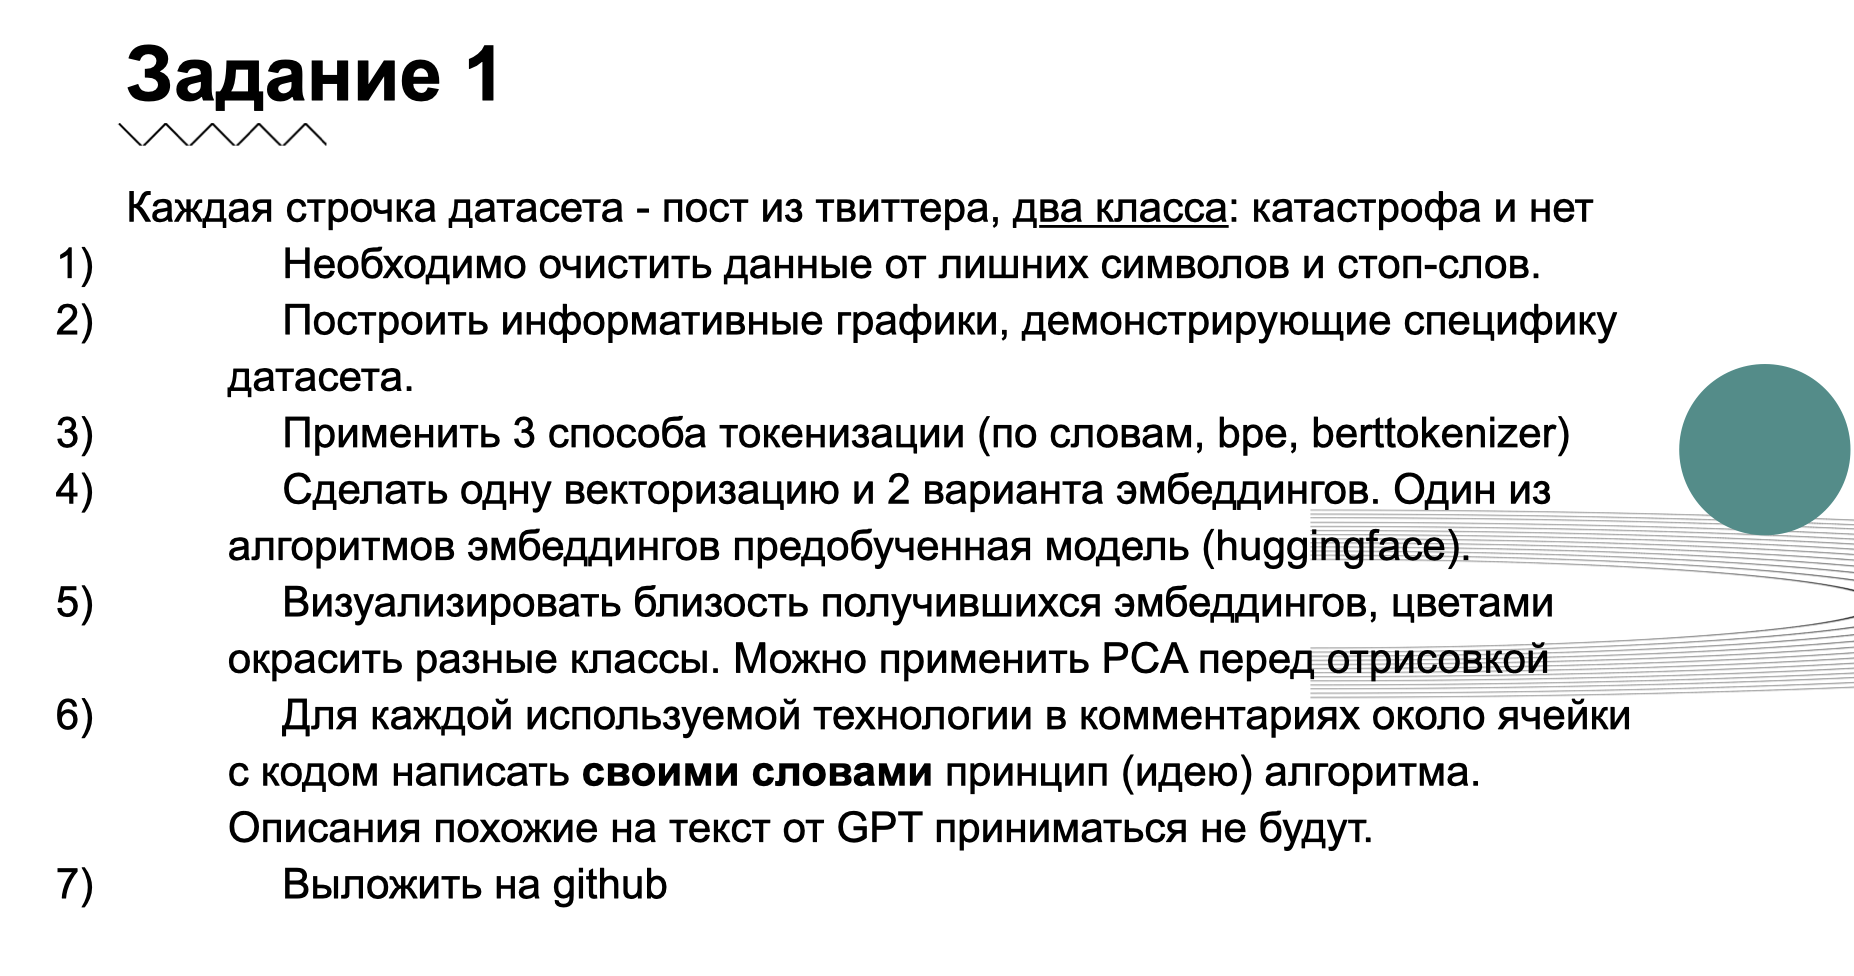
